# Differential Privacy (TEMPLATE)

In this notebook, we'll build a complete system for training neural networks with differential privacy. We'll start with the basics of DP, visualize its effects, and gradually build up to a full implementation of DP-SGD that you can drop into your training setups.

*Make a copy of this notebook before editing!*

In [4]:
# Imports
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
from tqdm import tqdm

# Part 1: Understanding Differential Privacy

First, let's visualize how differential privacy works with a simple example. We'll see how adding calibrated noise can protect individual data while preserving population-level statistics. Recall that we want to train a model that capture population-level trends without revealing any learnings from individual examples that one can exploit.

In [5]:
def visualize_dp_mechanism(data_size=1000, true_mean=50, true_std=10, noise_levels=None):
    """
    Visualize how Differential Privacy (DP) noise affects individual values vs population statistics.

    Args:
        data_size (int): Number of synthetic data points.
        true_mean (float): Mean of the true data distribution.
        true_std (float): Standard deviation of the true data.
        noise_levels (list of float, optional): Noise levels (σ values) to apply.
    """
    if noise_levels is None:
        noise_levels = [0.1, 1.0, 5.0]

    # Generate synthetic data
    data = torch.normal(true_mean, true_std, size=(data_size,))

    # Create subplots
    fig, axes = plt.subplots(1, len(noise_levels), figsize=(15, 5))

    for ax, sigma in zip(axes, noise_levels):
        # Apply Gaussian noise for DP
        noise = torch.normal(0, sigma, size=data.shape)
        noisy_data = data + noise

        # Plot distributions with density
        sns.histplot(data.numpy(), kde=True, bins=30, label="Original Data", color="blue", alpha=0.5, ax=ax)
        sns.histplot(noisy_data.numpy(), kde=True, bins=30, label=f"Noisy Data (σ={sigma})", color="red", alpha=0.5, ax=ax)

        # Compute means
        true_mean_val = data.mean().item()
        noisy_mean_val = noisy_data.mean().item()

        # Draw mean lines
        ax.axvline(true_mean_val, color="blue", linestyle="--", label=f"True Mean: {true_mean_val:.1f}")
        ax.axvline(noisy_mean_val, color="red", linestyle="--", label=f"Noisy Mean: {noisy_mean_val:.1f}")

        # Annotate mean shift
        ax.annotate(f"Δ = {abs(true_mean_val - noisy_mean_val):.2f}",
                    xy=(noisy_mean_val, ax.get_ylim()[1] * 0.8),
                    xytext=(noisy_mean_val + 5, ax.get_ylim()[1] * 0.85),
                    arrowprops=dict(arrowstyle="->", color="red"))

        ax.set_title(f"Noise σ = {sigma}")
        ax.legend()

    plt.suptitle("Effect of DP Noise on Data Distribution")
    plt.tight_layout()
    plt.show()

When we visualize, you'll see a histogram with blue bars representing the original noise distribution, and red representing the DP-noised distribution. Note that although each individual data point has been perturbed, the overall shape of the distribution still approximates normal.

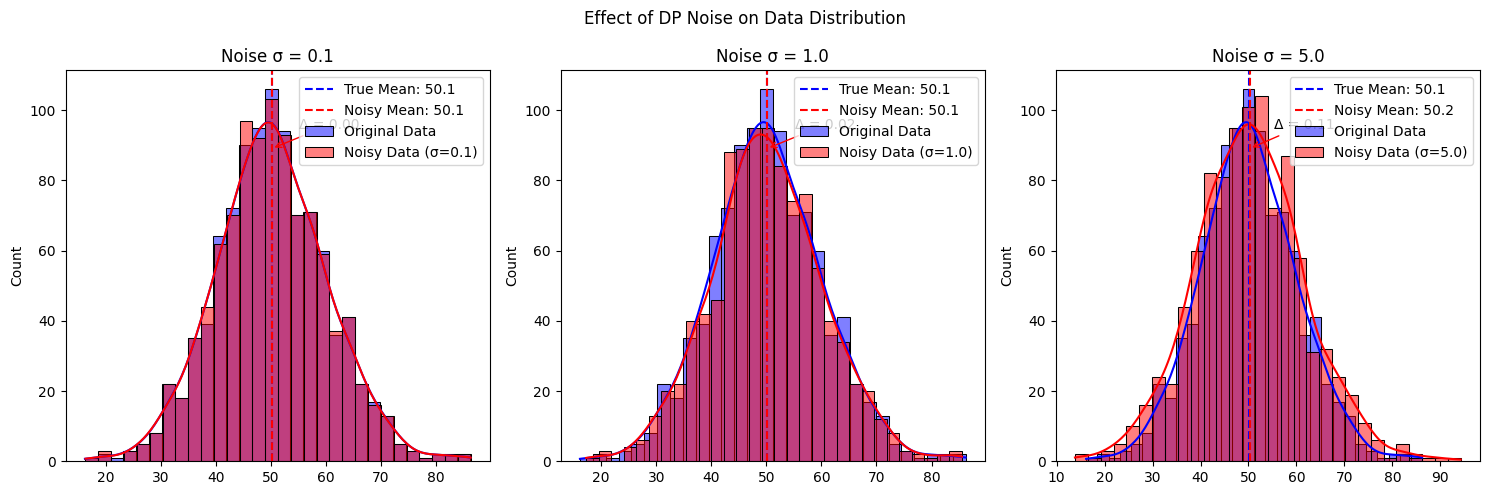

In [6]:
visualize_dp_mechanism()

# Part 2: Implementing DP-SGD

After that brief overview on what DP noise looks like, let's build a privacy-preserving optimizer (privacy-preserving learning algorithm).

Here are the components of DP-SGD we'll implement:
1. Per-sample gradient computation
2. Gradient clipping
3. Noise addition
4. Privacy budget tracking

After this, you'll have a feel for how libraries like Opacus work under the hood.


In [ ]:
class DPOptimizer:
    def __init__(self, params, lr=0.1, noise_multiplier=1.0, max_grad_norm=1.0,
                 use_per_sample_grads=False, use_gradient_clipping=False,
                 use_noise=False, use_momentum=False):
        """
        Configurable optimizer that can run with or without DP components.

        Parameters:
        - params: model parameters
        - lr: learning rate
        - noise_multiplier: scale of noise for DP
        - max_grad_norm: clipping threshold
        - use_per_sample_grads: if True, compute per-example gradients
        - use_gradient_clipping: if True, clip gradients
        - use_noise: if True, add DP noise
        - use_momentum: if True, use momentum for updates
        """
        self.params = list(params)
        self.lr = lr
        self.noise_multiplier = noise_multiplier
        self.max_grad_norm = max_grad_norm

        # DP configuration flags
        self.use_per_sample_grads = use_per_sample_grads
        self.use_gradient_clipping = use_gradient_clipping
        self.use_noise = use_noise
        self.use_momentum = use_momentum

        # Initialize momentum if used
        self.momentum_buffer = [torch.zeros_like(p.data) for p in self.params] if use_momentum else None

    def zero_grad(self):
        """
        TODO: Implement gradient zeroing.

        Questions:
        - Why do we need to zero gradients?
        - When should we zero them?
        """
        # YOUR CODE HERE
        for param in self.params:
          param.zero_grad()

        pass

    def compute_batch_gradient_and_loss(self, model, data, target):
        """
        TODO: Implement standard batch gradient computation (non-DP).

        Steps to implement:
        1. Zero existing gradients
        2. Compute model output
        3. Calculate loss
        4. Backpropagate
        5. Return gradients and loss

        Recall that your data will be given in batches. This should be similar
        to the inner portion of training loops you've written before.
        """
        # YOUR CODE HERE
        self.zero_grad();
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()

        grads = [p.grad.clone() for p in self.params]
        return grads, loss.item()

        pass

    def compute_sample_grads_and_loss(self, model, data, target):
        """
        TODO: Implement per-sample gradient computation (for DP).

        Steps to implement:
        1. Process each example separately
        2. Compute individual gradients
        3. Track individual losses
        """
        batch_size = data.size(0)
        individual_grads = []
        losses = []

        for i in range(batch_size):
            # YOUR CODE HERE
            pass

        return individual_grads, torch.stack(losses)

    def clip_gradients(self, grads):
        """
        TODO: Implement gradient clipping.

        Steps to implement:
        1. Calculate gradient norms
        2. Determine scaling factor
        3. Clip gradients if needed

        Questions:
        - Why is clipping necessary for DP?
        - How does max_grad_norm affect privacy if we inc/dec it?
        - What's the difference between batch and per-sample clipping?
        """
        if not isinstance(grads[0], list):
            # Handle batch gradients
            # YOUR CODE HERE
            total_norm = pass
            scaling_factor = pass
            return [g * scaling_factor for g in grads], total_norm.item()
        else:
            # Handle per-sample gradients
            clipped_grads = []
            total_norms = []
            for grad_list in grads:
                # YOUR CODE HERE
                pass
            return clipped_grads, np.mean(total_norms)

    def add_noise(self, grads, batch_size):
        """
        TODO: Implement noise addition for DP.

        Steps to implement:
        1. Handle both batch and per-sample cases
        2. Add calibrated Gaussian noise
        3. Scale noise appropriately

        Think about:
        - How does noise_multiplier affect privacy if we inc/dec it?
        - Why scale by batch_size?
        - How does batch size affect privacy and the noise we can add?
        """
        if not isinstance(grads[0], list):
            # Handle batch gradients
            # YOUR CODE HERE
            pass
        else:
            # Handle per-sample gradients
            noisy_grads = []
            for param_idx in range(len(self.params)):
                # YOUR CODE HERE
                pass
            return noisy_grads

    def apply_gradients(self, final_grads):
        """
        Apply gradients with optional momentum.

        We've already given the solution here to you.

        Think about:
        - Why does momentum help with noisy gradients?
        - How does momentum affect privacy?
        """
        if self.use_momentum:
            for i, (param, grad) in enumerate(zip(self.params, final_grads)):
                self.momentum_buffer[i] = 0.9 * self.momentum_buffer[i] + 0.1 * grad
                param.data -= self.lr * self.momentum_buffer[i]
        else:
            for param, grad in zip(self.params, final_grads):
                param.data -= self.lr * grad

    def step(self, model, data, target):
        """
        TODO: Perform one optimization step with configurable DP components.
        Returns loss and gradient norm for monitoring.

        You should:
        1. Compute gradients (batch or per-sample)
        2. Clip if enabled
        3. Add noise if enabled
        4. Apply updates

        Start by implementing the basic SGD case. This should be near identical
        to training loops you've written in the past for standard classifiers.
        Then, progressively add each DP component.

        Ask yourself:
        - What order should we apply the DP steps in and why?
        """
        batch_size = data.size(0)

        # YOUR CODE HERE
        # Compute gradients (per-sample or batch)
        if self.use_per_sample_grads:
            pass
        else:
            pass

        # Clip gradients if enabled
        if self.use_gradient_clipping:
            pass
        else:
            pass

        # Add noise if enabled
        if self.use_noise:
            pass

        # Apply gradients
        pass

        return loss_value, grad_norm

# Part 3: Privacy Budget Tracking [OPTIONAL]

Understanding and tracking privacy budget is crucial in DP-ML. The privacy engine helps us:
- Calculate required noise levels
- Track cumulative privacy loss
- Ensure we stay within our privacy budget

For now, we'll give you the code for a basic privacy engine. We'll return to this in a future notebook.

In [ ]:
class PrivacyEngine:
    def __init__(self, target_epsilon, target_delta, sample_rate):
        self.target_epsilon = target_epsilon
        self.target_delta = target_delta
        self.sample_rate = sample_rate  # batch_size / dataset_size
        self.steps = 0

        # Calculate noise multiplier for target privacy
        self.noise_multiplier = self._compute_initial_noise()

    def _compute_initial_noise(self):
        """
        Compute noise multiplier using the moments accountant.
        This is a simplified version - production systems use tighter bounds.
        """
        T = 1000  # Expected number of steps
        return (self.sample_rate * np.sqrt(T * np.log(1/self.target_delta))) / self.target_epsilon

    def step(self):
        """Track privacy consumption."""
        self.steps += 1
        current_epsilon = self._compute_current_epsilon()
        return current_epsilon

    def _compute_current_epsilon(self):
        """Compute current privacy loss."""
        return (self.sample_rate * np.sqrt(self.steps * np.log(1/self.target_delta))) / self.noise_multiplier

    def get_budget_left(self):
        """Return remaining privacy budget."""
        return max(0, self.target_epsilon - self._compute_current_epsilon())

# Part 4: Training!

## Part 4.1: Dataset

We'll provide some code below that lets you handle easily training on and swapping between datasets.

In [ ]:
class DatasetManager:
    """Handles dataset loading and preprocessing."""

    DATASET_CONFIGS = {
        'mnist': {
            'input_channels': 1,
            'num_classes': 10,
            'transform': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])
        },
        'cifar10': {
            'input_channels': 3,
            'num_classes': 10,
            'transform': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                  (0.2023, 0.1994, 0.2010))
            ])
        },
        # MNIST-M is a simulated medical dataset. We perturb MNIST images to
        # create a more challenging distribution to learn.
        'mnist-m': {
            'input_channels': 1,
            'num_classes': 10,
            'transform': transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
                # Add medical image simulation
                transforms.Lambda(lambda x: x + 0.1 * torch.randn_like(x))
            ])
        }
    }

    def __init__(self, dataset_name, data_dir='./data', batch_size=32):
        self.dataset_name = dataset_name
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.config = self.DATASET_CONFIGS[dataset_name]

    def load_dataset(self):
        """
        TODO: implement loading for each dataset.
        """

        if self.dataset_name == 'mnist':
            train_dataset = pass
            test_dataset = pass
        elif self.dataset_name == 'cifar10':
            train_dataset = pass
            test_dataset = pass
        # Add more datasets here as needed. We'll add MIMIC-CXR here.

        train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True
        )
        test_loader = DataLoader(
            test_dataset, batch_size=self.batch_size
        )

        return train_loader, test_loader, self.config

## Part 4.2: Training Framework

Now, you'll write a training framework that supports both standard and DP training. This will streamline our training and experimentation down the line.

In [ ]:
class Trainer:
    def __init__(self, model, dataset_manager, use_dp=False,
                 privacy_engine=None, use_per_sample_grads=True,
                 use_gradient_clipping=True, use_noise=True,
                 use_momentum=True, **training_args):
        self.model = model
        self.dataset_manager = dataset_manager
        self.use_dp = use_dp
        self.privacy_engine = privacy_engine
        self.training_args = training_args

        # Set up training components
        self.train_loader, self.test_loader, self.config = dataset_manager.load_dataset()

        """
        TODO: Initialize the appropriate optimizer

        Set up DP and standard (torch optim) optimizers

        Think about:
        - What parameters does each optimizer need?
        """
        if use_dp:
            self.optimizer = pass
        else:
            self.optimizer = pass


    def train_epoch(self):
        """Train for one epoch."""
        self.model.train()
        epoch_metrics = {'loss': 0, 'accuracy': 0}
        num_batches = len(self.train_loader)

        progress_bar = tqdm(self.train_loader, desc='Training')
        for batch_idx, (data, target) in enumerate(progress_bar):
            data, target = data.to(device), target.to(device)

            # TODO: Implement training step
            if self.use_dp:
                # YOUR CODE HERE
                # DP training step - returns loss value directly
                loss_value, grad_norm = pass

                if self.privacy_engine:
                    current_epsilon = self.privacy_engine.step()
                    epoch_metrics['epsilon'] = current_epsilon
                epoch_metrics['grad_norm'] = grad_norm

                # Compute accuracy
                with torch.no_grad():
                    # YOUR CODE HERE
                    # Take an opitmiztation step, track privacy budget, and
                    # computer accurcacy.
                    pass

            else:
                # YOUR CODE HERE
                # Zero grads, forward pass + loss + backwards pass
                # Optimizer step
                # Compute loss_value, pred, correct, accuracy
                pass

            # Update metrics
            epoch_metrics['loss'] += loss_value
            epoch_metrics['accuracy'] += accuracy

            # Update progress bar
            progress_bar.set_postfix(
                loss=loss_value,
                acc=accuracy,
                eps=epoch_metrics.get('epsilon', 0)
            )

        # Average metrics
        for key in epoch_metrics:
            epoch_metrics[key] /= num_batches

        return epoch_metrics

    def evaluate(self):
        """Evaluate model on test set."""
        self.model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(device), target.to(device)
                output = self.model(data)
                test_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

        test_loss /= total
        accuracy = correct / total

        return {'test_loss': test_loss, 'test_accuracy': accuracy}

    def train(self, epochs):
        """Complete training loop with history tracking."""
        history = {'train': [], 'test': []}

        # TODO: implement training loop
        # Make sure training loop works for both DP and non-DP training
        for epoch in range(epochs):
            # Train
            # Run training loop
            # Add train metrics to history['train']

            # Evaluate
            # Reun evaluation
            # Add test metrics to history['test']

            # Print progress
            print(f'\nEpoch {epoch+1}/{epochs}:')
            print(f'Train Loss: {train_metrics["loss"]:.4f}')
            print(f'Train Accuracy: {train_metrics["accuracy"]:.4f}')
            if self.use_dp:
                print(f'Privacy Budget (ε): {train_metrics.get("epsilon", 0):.2f}')
            print(f'Test Loss: {test_metrics["test_loss"]:.4f}')
            print(f'Test Accuracy: {test_metrics["test_accuracy"]:.4f}\n')

        return history

## Part 4.3: Evaluation

We provide some helper functions here to visualize your experimental results.

In [ ]:
class ExperimentVisualizer:
    def __init__(self, dp_history=None, non_dp_history=None):
        self.dp_history = dp_history
        self.non_dp_history = non_dp_history

    def plot_training_comparison(self):
        """Compare DP vs non-DP training metrics."""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        # Training Loss
        if self.non_dp_history:
            ax1.plot([m['loss'] for m in self.non_dp_history['train']],
                    label='Standard Training')
        if self.dp_history:
            ax1.plot([m['loss'] for m in self.dp_history['train']],
                    label='DP Training')
        ax1.set_title('Training Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Training Accuracy
        if self.non_dp_history:
            ax2.plot([m['accuracy'] for m in self.non_dp_history['train']],
                    label='Standard Training')
        if self.dp_history:
            ax2.plot([m['accuracy'] for m in self.dp_history['train']],
                    label='DP Training')
        ax2.set_title('Training Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()

        # Test Accuracy
        if self.non_dp_history:
            ax3.plot([m['test_accuracy'] for m in self.non_dp_history['test']],
                    label='Standard Training')
        if self.dp_history:
            ax3.plot([m['test_accuracy'] for m in self.dp_history['test']],
                    label='DP Training')
        ax3.set_title('Test Accuracy')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Accuracy')
        ax3.legend()

        # Privacy Budget (if applicable)
        if self.dp_history:
            ax4.plot([m.get('epsilon', 0) for m in self.dp_history['train']])
            ax4.set_title('Privacy Budget Usage (ε)')
            ax4.set_xlabel('Epoch')
            ax4.set_ylabel('ε')

        plt.tight_layout()
        plt.show()

    def analyze_privacy_utility_tradeoff(self):
        """Analyze privacy-utility tradeoff."""
        if not self.dp_history:
            print("No DP training data available.")
            return

        epsilons = [m.get('epsilon', 0) for m in self.dp_history['train']]
        accuracies = [m['test_accuracy'] for m in self.dp_history['test']]

        plt.figure(figsize=(10, 6))
        plt.plot(epsilons, accuracies, 'o-')
        plt.title('Privacy-Utility Trade-off')
        plt.xlabel('Privacy Budget (ε)')
        plt.ylabel('Test Accuracy')
        plt.grid(True)
        plt.show()

# Part 5: Experiments

Now you'll run some experiments to compare DP and non-DP training across different settings!

First, define your model architectures down here:

In [ ]:
class SimpleCNN(nn.Module):
    """Basic CNN for MNIST-like datasets (28x28 images)"""
    def __init__(self, in_channels=1, num_classes=10):
        super().__init__()
        # TODO: design your architecture here
        pass

    def forward(self, x):
        # TODO: implement your forwards pass
        return x

class CIFAR10CNN(nn.Module):
    """CIFAR-10-like datasets (32x32 color images)"""
    def __init__(self):
        super().__init__()
        # TODO: design your architecture here
        pass

    def forward(self, x):
        # TODO: implement your forwards pass
        return x

## Part 5.1: Basic DP vs Non-DP Training

Let's compare training with and without DP on MNIST! Pay attention to the extend of the privacy-utility tradeoff

Let's start by comparing standard training with DP training on MNIST. This will help us understand the basic privacy-utility trade-off.

Recall that the way we set up our DP optimizer and trainer allows us to enable each DP component independently from each other. Try out different configurations!

In [ ]:
# Hyperparameters
batch_size = 256
epochs = 10
device = torch.device('mps' if torch.backends.mps.is_available() else
                     'cuda' if torch.cuda.is_available() else 'cpu')

# Dataset
dataset_manager = DatasetManager('mnist', batch_size=batch_size)
train_loader, test_loader, config = dataset_manager.load_dataset()

# Create base model
model = SimpleCNN(
    in_channels=config['input_channels'],
    num_classes=config['num_classes']
).to(device)

Now, we'll train both the DP and standard model to compare.

In [ ]:
# DP training
print("\nTraining DP model...")

# TODO: set up privacy engine and DP trainer
privacy_engine = pass
dp_trainer = pass

# Standard training
print("Training standard model...")
# TODO: set up standard trainer
standard_trainer = pass

# Train
dp_history = dp_trainer.train(epochs)
non_dp_history = standard_trainer.train(epochs)


Training DP model...


Training:  22%|██▏       | 52/235 [00:32<01:52,  1.62it/s, acc=0.461, eps=0.691, loss=2.11]

In [ ]:
# Visualize results
visualizer = ExperimentVisualizer(dp_history, non_dp_history)
visualizer.plot_training_comparison()

## Part 5.2: Privacy Budget Impact

Next, let's explore how different privacy budgets (diffrent $\epsilon$ values) affect learning.

This will demonstrate precisely the privacy-utility tradeoff.

In [ ]:
# TODO: select epsilon values
epsilon_values = [?, ?, ?, ?, ?, ?]  # Different privacy levels
dp_results = {}

for epsilon in epsilon_values:
    # TODO: fill in experiment
    print(f"\nTraining with eps = {epsilon}")

    # TODO: Configure privacy engine for this experiment

    # TODO: Train model with this privacy setting

    # TODO: save results
    dp_results[epsilon] = ???.train(epochs)

In [ ]:
# Visualize privacy-utility trade-off
plt.figure(figsize=(10, 6))
for epsilon, history in dp_results.items():
    final_acc = history['test'][-1]['test_accuracy']
    plt.scatter(epsilon, final_acc, s=100, label=f'ε={epsilon}')

plt.axhline(y=non_dp_history['test'][-1]['test_accuracy'],
           color='r', linestyle='--', label='Non-DP Accuracy')
plt.xscale('log')
plt.xlabel('Privacy Budget (ε)')
plt.ylabel('Final Test Accuracy')
plt.title('Privacy-Utility Trade-off')
plt.legend()
plt.grid(True)
plt.show()

## Part 5.3: DP Components [PROVIDED]

Let's analyze how each component of DP-SGD affects training. We'll perform an **ablation study**, where we remove each component and observe the effects on the model's learning. In future weeks, we'll also observe effects on the model's vulnerability.

In [ ]:
# Test different DP component combinations
component_configs = [
    {
        'name': 'Only Per-sample Gradients',
        'use_per_sample_grads': True,
        'use_gradient_clipping': False,
        'use_noise': False
    },
    {
        'name': 'Per-sample + Clipping',
        'use_per_sample_grads': True,
        'use_gradient_clipping': True,
        'use_noise': False
    },
    {
        'name': 'Full DP-SGD',
        'use_per_sample_grads': True,
        'use_gradient_clipping': True,
        'use_noise': True
    }
]

component_results = {}
for config in component_configs:
    print(f"\nTesting configuration: {config['name']}")
    trainer = Trainer(
        model=copy.deepcopy(model),
        dataset_manager=dataset_manager,
        use_dp=True,
        privacy_engine=privacy_engine,
        **config,
        lr=0.1
    )
    component_results[config['name']] = trainer.train(epochs)

# Visualize how different components affect training
plt.figure(figsize=(12, 5))
for name, history in component_results.items():
    plt.plot([m['accuracy'] for m in history['train']], label=name)

plt.plot([m['accuracy'] for m in non_dp_history['train']],
         label='Standard SGD', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Impact of Different DP Components')
plt.legend()
plt.grid(True)
plt.show()